In [1]:
#!pip install rasterio
#!pip uninstall rasterio -y
#!pip install --upgrade rasterio

#!pip install mgwr
#!pip install --upgrade mgwr

import rasterio
from rasterio import warp
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from rasterio.plot import show
from rasterio.transform import from_origin # for creating a raster
#from rasterio.warp import calculate_default_transform, reproject, Resampling # for reprojecting rasters

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score

from mgwr.gwr import GWR
#from mgwr.sel import Sel_BW
from mgwr.sel_bw import Sel_BW
from shapely.geometry import Point

In [2]:
# general setup
#
# only this cell needs to be modified to target the pollutant of interest !!!
# all other parts of the script are adapted automatically
#############################################################################

# setup of pollutants: 1 = NO, 2 = NO₂, 3 = BC, 4 = PM
setup=4

In [3]:
# define pollutant setting
##########################

if setup == 1:
    pollutant="no" # label/abbreviation of the pollutant of interest (for saved files and input data path)
    pollutant_label="NO" # label/abbreviation of the pollutant of interest (for plot titles)
    pollutant_unit="ppb" # unit of the pollutant of interest, e.g. "µg/m³" for BC and PM, "ppb" for NO and NO₂
elif setup == 2:
    pollutant="no2"
    pollutant_label="NO₂"
    pollutant_unit="ppb"
elif setup == 3:
    pollutant="bc"
    pollutant_label="BC"
    pollutant_unit="µg/m³"
elif setup == 4:
    pollutant="pm"
    pollutant_label="PM"
    pollutant_unit="µg/m³"
else:
    raise ValueError("Setup was specified incorrectly, please chose an integer value in range 1 to 4!")

In [4]:
# define data paths
###################

pop_path="./rawdata/usa_ppp_2020.tif" # population data
pol_path="./rawdata/aa12_"+pollutant.replace("₂","2").lower()+"300m/w001001.adf" # pollution data (dependent on pollutant setup above)

In [5]:
# read data and align them
##########################

# open pol reference grid and get the shape
with rasterio.open(pol_path) as pol:
    pol_raster=pol.read(1)  # get first band of the grid
    pol_meta=pol.meta.copy()
    pol_width=pol.width
    pol_height=pol.height
    pol_transform=pol.transform

# define new boundaries (xmin, ymin, xmax, ymax)
bounds_new=pol.bounds

# define a new transform for aligning to the smaller extent
transform_new=rasterio.transform.from_origin(
    bounds_new[0],  # pol x coordinate (upper left)
    bounds_new[3],  # pol y coordinate (upper left)
    pol_transform[0],  # pol pixel size in x direction
    -pol_transform[4]   # pol pixel size in y direction (negative due to top left origin)
)

# set an empty array for taking on the reprojected data
reprojected_data=np.empty((pol_height,pol_width),dtype=pol_meta["dtype"])

# coordinate extent for loading the pop data around the research area (xmin, ymin, xmax, ymax)
extent=(-75,40,-73,41)

# open pop grid that will be reprojected according to the specifications above
with rasterio.open(pop_path) as pop: # as XY should just be considered as a dummy here !!
    window=from_bounds(*extent,transform=pop.transform) # window for reading the data
    pop_raster=pop.read(1,window=window)  # data within window are taken (1 takes only the first element from (bands, height, width))
    transform_window=pop.window_transform(window) # transform for the windowed data
    
    # reprojection of the grid to the newly defined extent
    warp.reproject(
        #source=pop.read(1),  # take first band from pop
        source=pop_raster,
        destination=reprojected_data,
        src_transform=transform_window,
        src_crs=pop.crs,
        dst_transform=transform_new,
        dst_crs=pol_meta["crs"],
        shape=(pol_height,pol_width),
        #resampling=Resampling.nearest
        resampling=Resampling.sum # sum to preserve the sum of cell values (in case of total population counts)
    )

    # update metadata
    pol_meta.update({
        "driver":"GTiff",
        "height":pol_height,
        "width":pol_width,
        "transform":transform_new,
        "nodata":-1  # user defined no data value
    })

    # save the reprojected/aligned raster as new file
    with rasterio.open("./results/pop_aligned.tif","w",**pol_meta) as dst:
        dst.write(reprojected_data,1)  # assign all reprojected data to the first band

# set the population raster as the now filled array created above
pop_raster=reprojected_data

In [6]:
# some checks
#############

if pop_raster.shape != pol_raster.shape:
    raise ValueError("Rasters do not have the same dimension/were not correctly aligned!")
else:
    print("Rasters were loaded and are aligned correctly!")

Rasters were loaded and are aligned correctly!


In [7]:
# prepare data for GWR
######################

# convert raster values to a dataframe
rows,cols=np.indices(pop_raster.shape)
coords=gpd.GeoDataFrame({
    "geometry":[Point(transform_new*(col+0.5,row+0.5)) for row,col in zip(rows.flatten(),cols.flatten())],
    "pop":pop_raster.flatten(),
    "pol":pol_raster.flatten()
})

# select only cases where the defined condition applies (filter NaN values and cases where only pop or pol has a value)
coords=coords[(coords["pop"]>=0)&(coords["pol"]>=0)] # select rows with the defined condition
xy_coords=np.column_stack((coords.geometry.x.values,coords.geometry.y.values))
pop_input=coords[["pop"]].to_numpy() # reshape to a 2D numpy-array (needed in this format for the GWR below) !!!!!
pol_input=coords[["pol"]].to_numpy()

In [8]:
# some checks
#############

print(f"xy_coords ... shape: {xy_coords.shape}, type: {type(xy_coords)}")
print(f"pol_input ... shape: {pol_input.shape}, type: {type(pol_input)}")
print(f"pop_input ... shape: {pop_input.shape}, type: {type(pop_input)}")

xy_coords ... shape: (8114, 2), type: <class 'numpy.ndarray'>
pol_input ... shape: (8114, 1), type: <class 'numpy.ndarray'>
pop_input ... shape: (8114, 1), type: <class 'numpy.ndarray'>


In [9]:
# perform the GWR
#################

#GWR? # get some general infos on the GWR library

# scale the independent variables
#from sklearn.preprocessing import StandardScaler
#scaler=StandardScaler()
#pop_input_scaled=scaler.fit_transform(pop_input)

# automatically select the bandwidth for GWR (not working, because resulting bandwith smaller than pixel size)
#selector=Sel_BW(xy_coords,pol_input,pop_input_scaled)
#bandwith_auto=selector.search()
#print('The auto-bandwith is:',bandwith_auto)

# define a fixed bandwidth manually
bandwidth=5000

# compute/fit GWR model
gwr_model=GWR(coords=xy_coords,
              y=pol_input,
              X=pop_input,
              bw=bandwidth,
              kernel="gaussian").fit()

gwr_model.summary() # show summary of the GWR model

Model type                                                         Gaussian
Number of observations:                                                8114
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2596.714
Log-likelihood:                                                   -6890.947
AIC:                                                              13785.895
AICc:                                                             13787.898
BIC:                                                             -70422.207
R2:                                                                   0.155
Adj. R2:                                                              0.155

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [10]:
# save results of the GWR (as csv and tif)
##########################################

# extract metrics/estimates of interest from the GWR result
local_x1_estimates=gwr_model.params[:,1] # extract local x1 (coefficient of first predictor) values
local_r2_estimates=gwr_model.localR2 # extract local R^2 values

# generate dataframe with the local gwr estimates of interest and xy coordinates 
gwr_df=pd.DataFrame({
    "longitude":xy_coords[:,0], # define column with x-coordinate values
    "latitude":xy_coords[:,1], # define column with y-coordinate values
    "local_x1_estimate":local_x1_estimates,
    "local_R2_estimate":local_r2_estimates.flatten()
})

# create a data frame of the variable labels of interest
gwr_value_df=["x1","r2"]

for i in range(gwr_df.shape[1]-2): # define the range as column count minus 2 (to do not count the two lon lat columns)
    gwr_value=gwr_value_df[i]
    gwr_output=gwr_df.iloc[:,[0,1,i+2]] # choose the targeted column combination for the new data frame gwr_output (here +2 to skip the 2 lon lat colums)
    #print(gwr_output)

    gwr_output.to_csv("./results/gwr_local_"+gwr_value+"_estimates_"+pollutant+".csv",index=False) # save as csv
    print("local x1 estimates saved as gwr_local_"+gwr_value+"_estimates_"+pollutant+".csv")

    # create empty raster array with nodata values (-9999)
    raster_template=np.full((pol_height,pol_width),-9999,dtype="float32")
    
    # generate row and column indices from the coordinates in the dataframe
    x_index=((gwr_output["longitude"]-transform_new[2])/transform_new[0]).astype(int) # longitude to column index (distance between longitude and upper left corner divided by pixel size in x-direction for discretizing the distance into pixel units)
    y_index=((transform_new[5]-gwr_output["latitude"])/-transform_new[4]).astype(int) # latitude to row index (same as above with switched signs to account for the direction up to down)
    
    # fill empty raster with the local values via iteration/loop over all local values (via "enumerate" function/statement to get both, the value and corresponding index at once)
    for i, local_value in enumerate(gwr_output.iloc[:,2]): # access the third column in the data frame (the one holding the GWR value information) with ".iloc[:,2]"
        raster_template[y_index[i],x_index[i]]=local_value # assign local values to the correct row and column (= location) within the grid template
    
    # save the filled raster as a file
    with rasterio.open(
        "./results/gwr_local_"+gwr_value+"_estimates_"+pollutant+".tif",
        "w",
        driver="GTiff",
        height=pol_height,
        width=pol_width,
        count=1, # define number of bands in the raster
        dtype="float32",
        crs=pol_meta["crs"],
        transform=transform_new,
        nodata=-9999
    ) as dst:
        dst.write(raster_template,1)  # write data to first raster band
    
    print("local value results saved as gwr_local_"+gwr_value+"_estimates_"+pollutant+".tif")


local x1 estimates saved as gwr_local_x1_estimates_pm.csv
local value results saved as gwr_local_x1_estimates_pm.tif
local x1 estimates saved as gwr_local_r2_estimates_pm.csv
local value results saved as gwr_local_r2_estimates_pm.tif


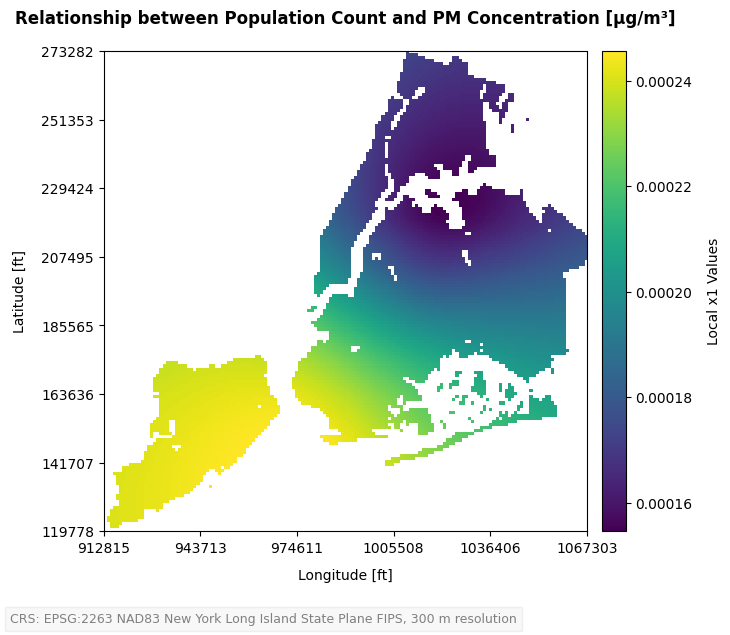

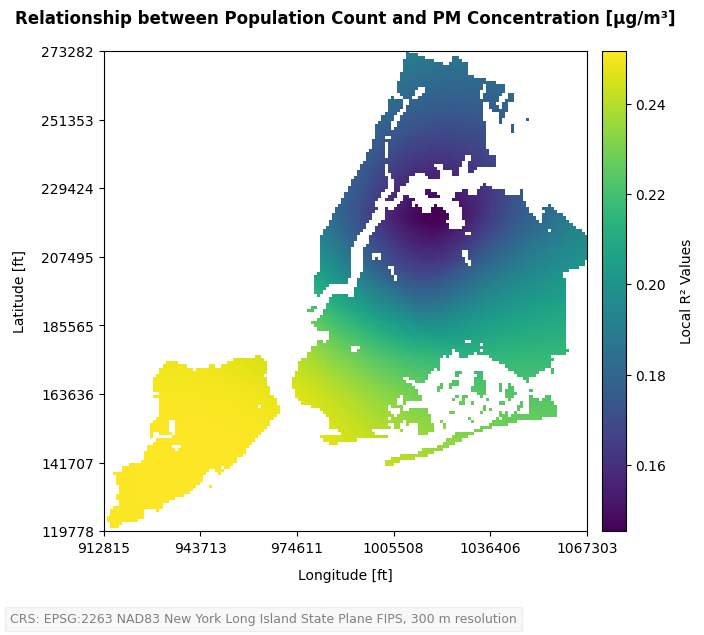

In [11]:
# some plots
############

# create a data frame of the variable labels of interest
gwr_value_df=["x1","r2"]

# create a loop to plot through all variables of interest
for gwr_value in gwr_value_df:

    # define a nicer label conditionally
    if gwr_value == "r2":
        gwr_value2="R²"
    else:
        gwr_value2="x1"
    
    # open raster to be plotted (and reproject crs)
    with rasterio.open("./results/gwr_local_"+gwr_value+"_estimates_"+pollutant+".tif") as r:
        raster=r.read(1) # get first band of the grid
        crs=r.crs
        nodata_value=r.nodata # get the nodata value
        # mask out nodata values if there are any
        if nodata_value is not None:
            raster=np.ma.masked_equal(raster,nodata_value)
        # get bounds of the grid in the current crs
        left,bottom,right,top=r.bounds # spatial coordinates in grid crs
    
    # create the plot
    plt.figure(figsize=(10,6))
    plot=plt.imshow(raster,
                    cmap="viridis",
                    origin="upper",
                    #extent=r.bounds,
                    extent=(left,right,bottom,top),
                    #extent=(912815,1067303,119778,273282)
                   )
    #plt.colorbar(label="Local "+value2+" Values",labelpad=5)
    colorbar=plt.colorbar(plot,orientation="vertical",pad=0.02) # create colorbar outside plot (adjust space to the right)
    colorbar.set_label("Local " + gwr_value2 + " Values",labelpad=10)
    #colorbar.ax.yaxis.set_tick_params(labelsize=10) # colorbar tick label size
    #colorbar.ax.set_yticklabels([f"{tick:.2f}" for tick in colorbar.get_ticks()]) # colorbar labels decimal places
    plt.title("Relationship between Population Count and "+pollutant_label+" Concentration ["+pollutant_unit+"]",pad=20,fontweight="bold")
    plt.xlabel("Longitude [ft]",labelpad=10)
    plt.ylabel("Latitude [ft]",labelpad=10)
    x_ticks=np.linspace(left,right,num=6)  # adjust number of x_ticks
    y_ticks=np.linspace(bottom,top,num=8)  # adjust number of y_ticks 
    plt.xticks(x_ticks,[f"{tick:.0f}" for tick in x_ticks]) # {tick:.Xf} -> X defines the number of decimal places shown
    plt.yticks(y_ticks,[f"{tick:.0f}" for tick in y_ticks])
    #ctx.add_basemap(ax,crs=r.crs.to_string(),source=ctx.providers.Stamen.Terrain) # add OSM basemap (contextily library needed)
    #plt.show() # do this only after saving it as a file, otherwise the file will not be generated correctly
    plt.text(left-30000,bottom-30000,
             #"CRS: EPSG:2263",
             #f"CRS: {crs}, NAD83 New York Long Island State Plane FIPS, 300 m resolution",
             f"CRS: EPSG:2263 NAD83 New York Long Island State Plane FIPS, 300 m resolution",
             fontsize=9,
             color="grey",
             ha="left",
             va="bottom", 
             rotation=0,
             fontweight="light",
             bbox=dict(facecolor="grey",alpha=0.05)
            )
    
    #plt.subplots_adjust(right=0.85) # adjust layout to avoid overlap and ensure enough space for the colorbar on the right
    plt.subplots_adjust(left=0.1,right=0.85,top=0.9,bottom=0.1)
    
    # save the plot as file and show it
    plt.savefig("./results/gwr_local_"+gwr_value+"_estimates_"+pollutant+"_map.jpg",dpi=300,bbox_inches="tight",pad_inches=0.1)
    plt.show()